# COVID-19 Vaccine Sentiment Analysis

## The Author
Author: Alim Ikegami

## Sentiment Analysis
Sentiment analysis is used to extracts the public's opinion about certain action/product to help the institution behind that particular action/product to understand how people perceive certain action/product.

## The Data
source: https://www.kaggle.com/datasciencetool/covid19-vaccine-tweets-with-sentiment-annotation

#### The Goal: Create a Machine Learning Algorithm that can predict if a tweet is positive, neutral, or negative. In the future, we could use such an algorithm to automatically read and flag tweets for the government or medical institution regarding on the opinion of general public about the vaccine. 

## Import neccessary libraries

In [1]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import re
from collections import Counter
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

pd.options.display.max_colwidth = 200

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alimi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alimi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Reading the dataset
df = pd.read_csv('C:\\Users\\alimi\\My Python Stuff\\Vaccine-Sentiment-Analysis\\covid-19_vaccine_tweets_with_sentiment.csv', encoding="windows-1252")

In [3]:
df.head()

,tweet_id,label,tweet_text
0,1.360340e+18,1,"4,000 a day dying from the so called Covid-19 ""vaccine"" @DailyBeast reports. #vaccine #PfizerVaccine #Moderna \n\nhttps://t.co/p1nQWWZpk4"
1,1.382900e+18,2,Pranam message for today manifested in Dhyan by @meenapranam #truth #love #karm #light #nature #consciousness #FridayThoughts #fridaymorning #CoronavirusIndia #COVID19India #?????_???????? #navrat...
2,1.375670e+18,2,"Hyderabad-based ?@BharatBiotech? has sought funds from the government to ramp up production of its indigenously developed Covid-19 vaccine, #Covaxin .\nThe company has written to the ??@DBTIndia? ..."
3,1.381310e+18,1,"Confirmation that Chinese #vaccines ""don’t have very high protection rates"", according to the director of the China Centers for Disease Control, Gao Fu.\n\n#Sinovac effectiveness ""found to be as l..."
4,1.362170e+18,3,"Lab studies suggest #Pfizer, #Moderna vaccines can protect against #coronavirusvariant\nhttps://t.co/NPaFA68m57"


## Cleaning textual data using regex

The data that I got from kaggle still contains a lot of unnecassary data such as the link of the tweet that was presumably attached to the tweet when the scraping was done through tweepy (Twitter's API), the username of the users that are mentioned on a particular tweet, and some punctuation. So, the first thing that I'm going to do is clean the textual data.

In [4]:
# Removing the link of the tweets
result = []
for tweet in df['tweet_text']:
    result.append(re.sub(r"http\S+", "", tweet))
df['tweet_text_without_link'] = result

# removing the hash symbol on the hashtag thas was written on the tweets
# the hastag itself is not removed as it may contain important information
result = []
for tweet in df['tweet_text_without_link']:
    result.append(re.sub(r'#', "", tweet))
df['tweet_text_without_hash'] = result

# Removing the username of the account that are mentioned in the tweet
# The username doesn't really matter so I decided to remove it
result = []
for tweet in df['tweet_text_without_hash']:
    result.append(re.sub(r'@[^\s]+', "", tweet))
df['tweet_without_mentions'] = result

# Removing the punctuation
result = []
for tweet in df['tweet_without_mentions']:
    result.append(re.sub(r'[^\w\s]', "", tweet))
df['tweet_without_punctuation'] = result

# Removing the newline characters
result = []
for tweet in df['tweet_without_punctuation']:
    result.append(tweet.replace('\n',''))
df['tweet_without_newline'] = result

In [5]:
# Assembling the final dataframe that are going to be used on feature extraction and training
# The final dataframe only contains the tweets which has been cleaned and the label of each tweet
df_final = df[['tweet_without_newline', 'label']]

## Training and testing data splitting

In [6]:
X = df_final['tweet_without_newline']
y = df_final['label']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Exploratory Data Analysis (EDA)

C:\Users\alimi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

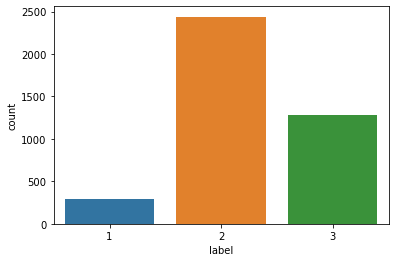

In [8]:
# Checking the distribution of the labels
sns.countplot(y_train)

The label 1 notates the negative sentiments, 2 notates the positive sentiments, and 3 notates the neutral sentiments. From the plot above, we can see that the data is pretty unbalanced because most of the tweets that are on the training dataset are labeled as positive.

In [9]:
# construct the training dataframe for further exploratory data analysis
train_df = pd.concat([X_train, y_train], axis=1)

### Splitting different classes to different dataframe

In [10]:
train_positive = train_df[train_df['label'] == 2]
train_negative = train_df[train_df['label'] == 1]
train_neutral = train_df[train_df['label'] == 3]

### Tokenizing each tweet on different classes
Tokenization is the process of splitting a sentence into words

In [11]:
words_positive = train_positive['tweet_without_newline'].apply(lambda x: str(x).split())
words_negative = train_negative['tweet_without_newline'].apply(lambda x: str(x).split())
words_neutral = train_neutral['tweet_without_newline'].apply(lambda x: str(x).split())

### Removing stopwords and lemmatizing each token
To see the words that are common on each class, we need to remove the stopwords and lemmatize each word into its root form.

In [12]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

clean_words_positive = []
for tweet in words_positive:
    temp = []
    for word in tweet:
        if (word not in stop_words):
            temp.append(lemmatizer.lemmatize(word.lower()))
    clean_words_positive.append(temp)

clean_words_negative = []
for tweet in words_negative:
    temp = []
    for word in tweet:
        if (word not in stop_words):
            temp.append(lemmatizer.lemmatize(word.lower()))
    clean_words_negative.append(temp)

clean_words_neutral = []
for tweet in words_neutral:
    temp = []
    for word in tweet:
        if (word not in stop_words):
            temp.append(lemmatizer.lemmatize(word.lower()))
    clean_words_neutral.append(temp)

### Counting how many times each word occurs

In [13]:
top_words_positive = Counter([token for tokens in clean_words_positive for token in tokens])
top_words_negative = Counter([token for tokens in clean_words_negative for token in tokens])
top_words_neutral = Counter([token for tokens in clean_words_neutral for token in tokens])

### Visualizing the most common words on each classes

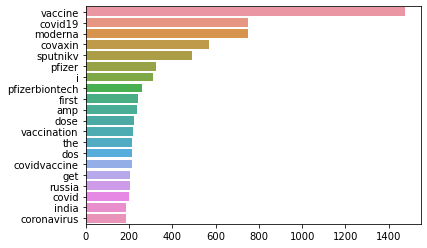

In [14]:
word = []
counter = []
for counts in top_words_positive.most_common(20):
    word.append(counts[0])
    counter.append(counts[1])

chart = sns.barplot(x=counter,y=word)

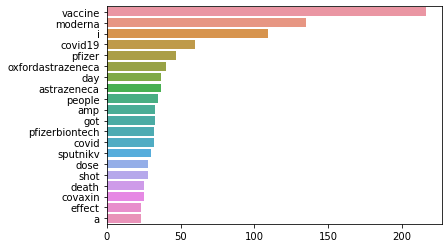

In [15]:
word = []
counter = []
for counts in top_words_negative.most_common(20):
    word.append(counts[0])
    counter.append(counts[1])

chart = sns.barplot(x=counter,y=word)

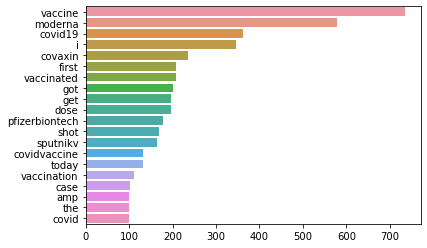

In [16]:
word = []
counter = []
for counts in top_words_neutral.most_common(20):
    word.append(counts[0])
    counter.append(counts[1])

chart = sns.barplot(x=counter,y=word)

From the visualization, we can see that most of the common words on each class are pretty similiar. For the positive class, most of the common words are the types of vaccines. For the negative class, the words that are unique to them are 'death' and 'effect'. For the neutral class, the words that are unique to them is 'got', which probably is the by product of tweets that are saying that they just got vaccinated. 

## Feature extraction

For the feature extraction, I'm going to use TF-IDF

In [17]:
tfidf = TfidfVectorizer(stop_words='english')

In [18]:
tfidf.fit(X_train)

TfidfVectorizer(stop_words='english')

In [19]:
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [20]:
X_train_tfidf

<4020x12566 sparse matrix of type '<class 'numpy.float64'>'
	with 55905 stored elements in Compressed Sparse Row format>

## Modelling

For the modelling phase, I will use SVM classifier as the baseline results. I might try to use deep learning approach for the next experiment.

In [21]:
svm_model = SVC(kernel = 'linear', C = 1)

In [22]:
svm_model.fit(X_train_tfidf, y_train)

SVC(C=1, kernel='linear')

In [23]:
pred = svm_model.predict(X_test_tfidf)

In [24]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.41      0.07      0.12       124
           2       0.76      0.88      0.82      1241
           3       0.70      0.60      0.65       615

    accuracy                           0.74      1980
   macro avg       0.62      0.52      0.53      1980
weighted avg       0.72      0.74      0.72      1980

